In [7]:
import os
import csv
import websocket
import json
import time
import joblib
import threading

from src.websocket_client import start_websocket, stop_websocket
from src.data_storage import save_data_to_csv
from src import websocket_client

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization
from sklearn.metrics import accuracy_score, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from src.data_storage import connect_to_mongo
from src.schemas.training_data import TrainingData

In [9]:
MODEL_DIR = "model"

## Data Extraction

In [12]:
# Fetch data from the API

start_websocket("history", total_count=20000)
raw_data = websocket_client.hist_data

Connected to Deriv API
Requesting 5000 more data points until latest...
Requesting 5000 more data points until 1738325622...
Requesting 5000 more data points until 1738315624...
Requesting 5000 more data points until 1738305626...
Completed fetching 20000 historical data points.
Disconnected from Deriv API


In [14]:
# Prepare data

timestamps = []
prices = []

for list in raw_data:
    timestamps.extend(list["history"]["times"][:-1])
    prices.extend(list["history"]["prices"][:-1])

ldps = [int("{:.2f}".format(value)[-1]) for value in prices]

In [ ]:
# Store data

save_data_to_csv({"timestamp": timestamps, "price": prices, "ldp": ldps})

# Establish a connection to MongoDB
db_names = connect_to_mongo()

# Save TrainingData to mongoDB
if "training_data" in db_names:
    TrainingData.drop_collection()
for i in range(len(timestamps)):
    prediction = TrainingData(
        time_stamp=timestamps[i], price=prices[i], LDP_prediction=ldps[i]
    )
    prediction.save()
print("TrainingData saved in mongoDB")

In [3]:
dataset = pd.read_csv("data/data.csv")
dataset

,Timestamp,Price,LDP
0,1738308038,1741.42,2
1,1738308040,1742.19,9
2,1738308042,1741.98,8
3,1738308044,1742.21,1
4,1738308046,1742.17,7
...,...,...,...
19991,1738288032,1838.85,5
19992,1738288034,1838.76,6
19993,1738288036,1839.32,2
19994,1738288038,1839.18,8


## Data Preprocessing

In [4]:
def process_data(dataframe, sequence_length=20):
    temp_df = dataframe.copy()

    features, target = [], []
    for i in range(len(temp_df) - sequence_length):
        scaler = MinMaxScaler()

        x = temp_df["Price"].values[i : i + sequence_length]
        features.append(scaler.fit_transform(x.reshape(-1, 1)))
        y = temp_df["Price"].values[i + sequence_length]
        target.append(scaler.transform(y.reshape(-1, 1)).flatten())

    features = np.array(features)
    features_reshaped = features.reshape(features.shape[0], features.shape[1], 1)
    target = np.array(target)

    return features_reshaped, target

In [80]:
# Load dataset
sequence_length = 100
X, y = process_data(dataset, sequence_length)

In [81]:
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

## Model Development

In [82]:
# Build model
def build_model(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),
            LSTM(120, return_sequences=True, activation="tanh"),
            BatchNormalization(),
            LSTM(64, return_sequences=False, activation="tanh"),
            BatchNormalization(),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
            Dense(1),
        ]
    )

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

In [83]:
model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 120)            │          58,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 120)            │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          47,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,281 (426.88 KB)

 Trainable params: 108,913 (425.44 KB)

 Non-trainable params: 368 (1.44 KB)

In [84]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
)

# # Save model
model.save(os.path.join(MODEL_DIR, "model.keras"))
print("Model Saved")

Epoch 1/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - loss: 0.0425 - mae: 0.1297 - val_loss: 0.0395 - val_mae: 0.1645
Epoch 2/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0265 - mae: 0.0870 - val_loss: 0.0123 - val_mae: 0.0887
Epoch 3/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0155 - mae: 0.0758 - val_loss: 0.0099 - val_mae: 0.0773
Epoch 4/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0318 - mae: 0.0773 - val_loss: 0.0078 - val_mae: 0.0680
Epoch 5/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0494 - mae: 0.0746 - val_loss: 0.0075 - val_mae: 0.0669
Epoch 6/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0104 - mae: 0.0670 - val_loss: 0.0189 - val_mae: 0.1142
Epoch 7/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0126 - mae: 0.0677 - val_loss: 0.0130 - val_mae: 0.0905
Epoch 8/100
498/498 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - loss: 0.0326 - mae: 0.0695 - val_loss: 0.0085 - val_mae: 0.0723
Epoch 9/100
498/498 ━━━━━━━━━━━━

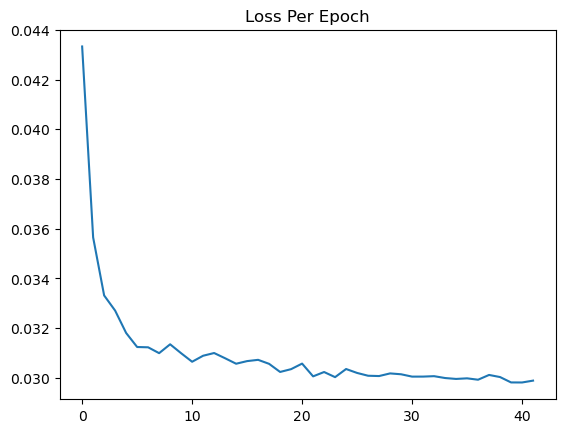

In [87]:
# Plot Loss
plt.plot(history.history["loss"])
plt.title("Loss Per Epoch")
plt.show()

## Model Evaluation

In [88]:
# Load saved model
model = load_model(os.path.join(MODEL_DIR, "model.keras"))

In [89]:
# Validation Prediction
val_predict = model.predict(X_val)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


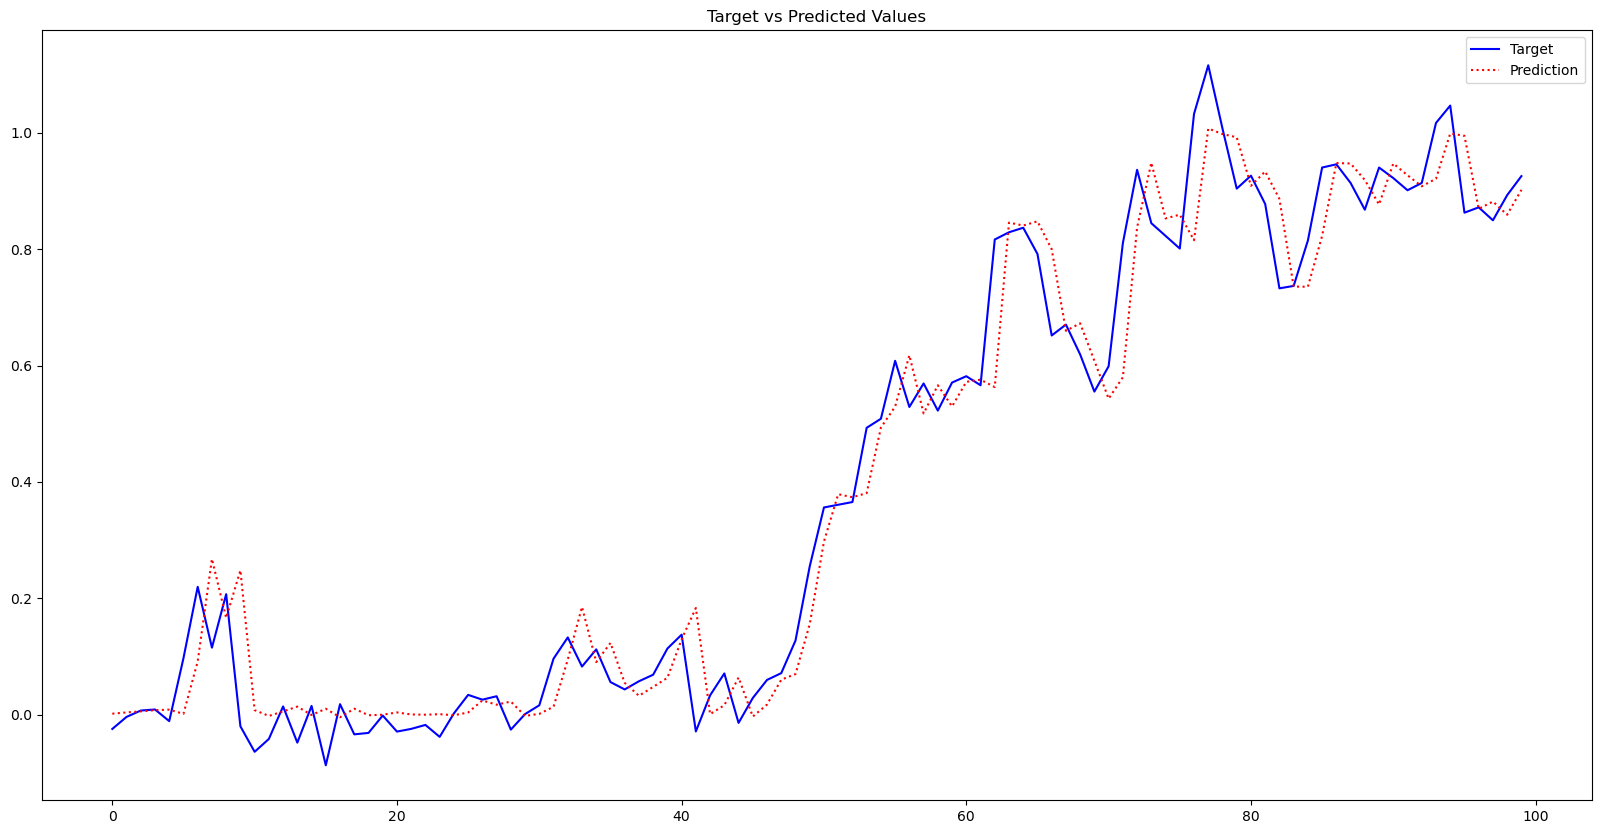

R2 Score: 0.9370641470474984


In [90]:
# Plot Validation Predictions
plot_range = 100
plt.figure(figsize=(20, 10))
plt.plot(y_val[:plot_range], label="Target", color="blue")
plt.plot(val_predict[:plot_range], label="Prediction", color="red", linestyle=":")
plt.legend()
plt.title("Target vs Predicted Values")
plt.show()

val_accuracy = r2_score(y_val, val_predict)
print("R2 Score:", val_accuracy)

In [91]:
# Test Prediction
test_df = pd.read_csv("data/test.csv")
X_test, y_test = process_data(test_df, sequence_length=40)
test_predict = model.predict(X_test)

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


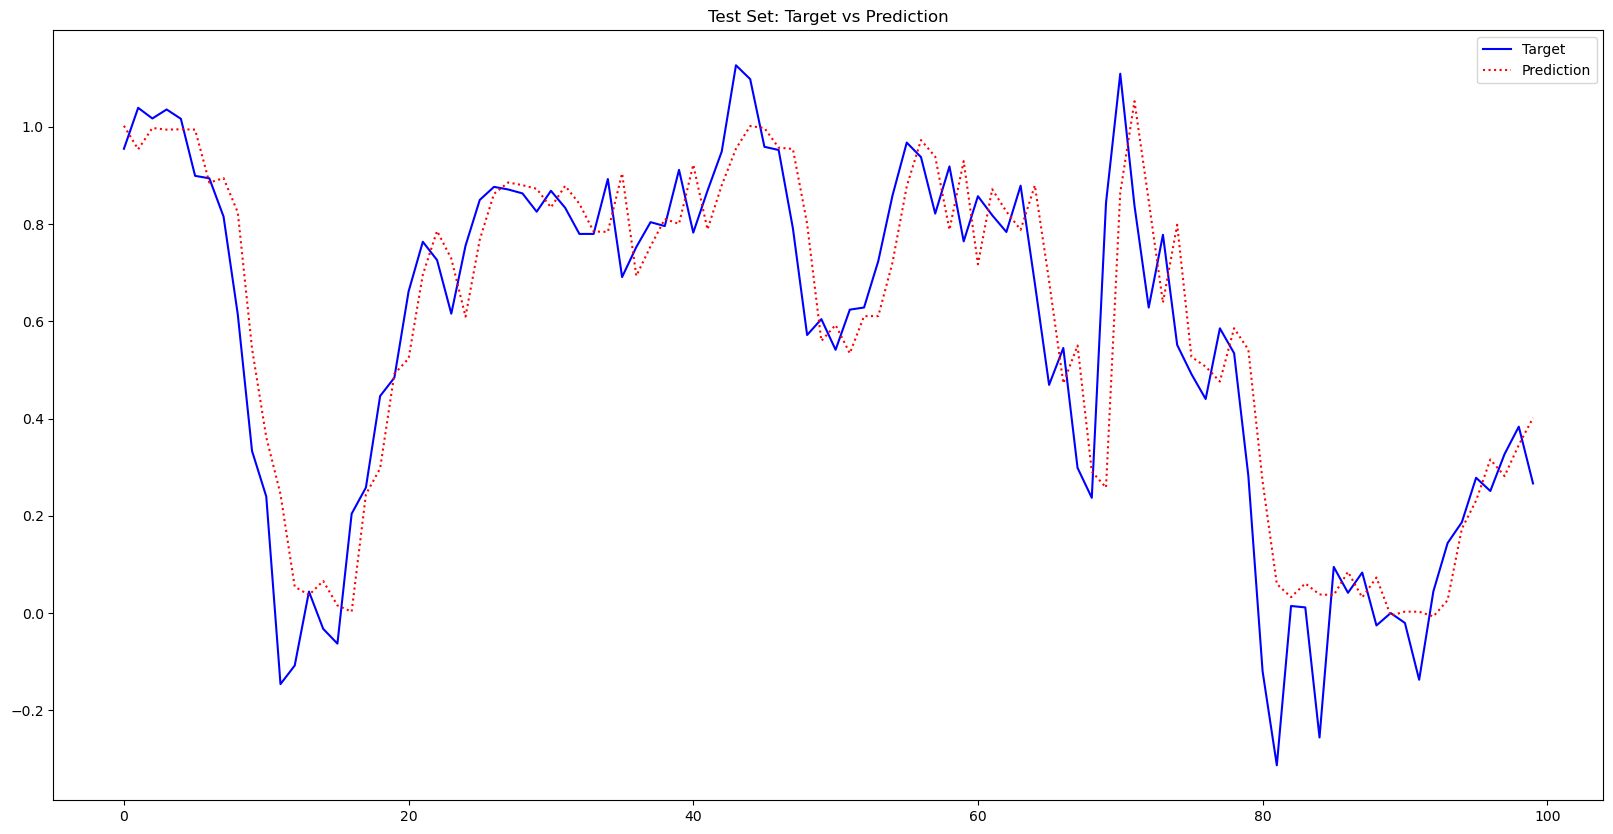

R2 Score: 0.8708316159176684


In [92]:
# Plot test Predictions
plot_range = 100
plt.figure(figsize=(20, 10))
plt.plot(y_test[:plot_range], label="Target", color="blue")
plt.plot(test_predict[:plot_range], label="Prediction", color="red", linestyle=":")
plt.legend()
plt.title("Test Set: Target vs Prediction")
plt.show()

test_accuracy = r2_score(y_test, test_predict)
print("R2 Score:", test_accuracy)